# Tehtävä 3 - K-nn -luokitin
Hannu Karstu - TTV19SAI

## Tehtävänanto

1. Tee dokumentin K-nearest neighbors – a lazy learning algorithm (Python Machine learning 3rd edition).pdf mukainen KNN-algortimi Jupyter notebookiin
2. Tutustu eri etäisyysparametreihin oheisen linkin kautta http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html 
3. Vertaile eri etäisyysparametreilla, kuinka luokittelutulos muuttuu. Dokumentoi vertailu Jupyter notebookiin
4. Tutustu gridsearchCV -algoritmin toimintaan ja implementoi se koodiisi. 
5. Etsi väliltä k = 1 … 12 optimaalisin k:n arvo
6. Selvitä, onnistuuko gridsearchCV-algoritmilla hakea optimaalinen parametripari sekä k:n arvolle 1…12 että etäisyyden mittaukselle (distance metric) menetelmillä (euclidean, minkowski, mahalanobis). 
7. Mikäli onnistuu, toteuta algoritmi edellä annetuilla vaatimuksilla
8. Kommentoi koodisi kattavasti

## 1. KNN-algoritmin tekeminen
Tee dokumentin K-nearest neighbors – a lazy learning algorithm (Python Machine learning 3rd edition).pdf mukainen KNN-algortimi Jupyter notebookiin

### 1.1 Datan lataus ja splittaus

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()

# Otetaan vain kaksi ekaa featurea
X = iris.data[:, :2]

# Label, eli kukan nimi
y = iris.target

# Splitataan treeni ja testidatoiksi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, 
    random_state=42)

# Tarkistetaan mittasuhteet
print("X_train",X_train.shape)
print("X_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

print(X[0],y[0])

X_train (100, 2)
X_test (50, 2)
y_train (100,)
y_test (50,)
[5.1 3.5] 0


### 1.2 Otetaan Plot_decision_regions käyttöön

In [68]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx, resolution=0.02):
    # Ulkoasumäärittelyt
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Luodaan jakoalueet
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                            np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    # Plotataan jakava viiva sarakkeiden arvojen perusteella
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
     # Plotataan aineiston pisteet
     ## Samanlainen plottaus kuin aiemmin, mutta vähän luettavampi ulkoasu
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')
    if test_idx:
      X_test, y_test = X[test_idx, :], y[test_idx]
      plt.scatter(X_test[:, 0], X_test[:, 1], c='',
               alpha=1.0, 
                  linewidth=1, 
                  marker='o',
                  s=55, label='test set', edgecolor='black')

### 1.3 Standardisoidaan tarvittavat

In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

print(X_train_std[0])

[-0.13835603 -0.26550845]


### 1.4 Yhdistetään datat

In [70]:
import numpy as np

X_combined_std = np.r_[X_train_std, X_test_std]
y_combined = np.r_[y_train, y_test]

print("X_combined_std",X_combined_std.shape)
print("y_combined",y_combined.shape)

X_combined_std (150, 2)
y_combined (150,)


### 1.5 Ajetaan KNN-luokitin

In [71]:
# KNN malli käyttäen Euclidean distance metriciä:    
  
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, p=2,
                           metric='minkowski')

knn.fit(X_train_std, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

### 1.6 Plotataan data ja decision regionit

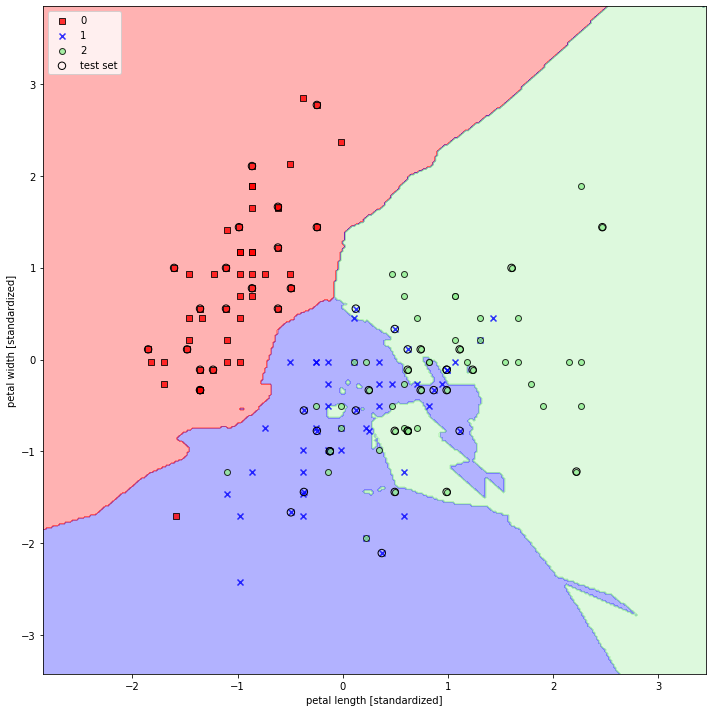

In [72]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=knn, test_idx=range(101,150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()


plt.show()

### 1.7 Testataan mallin suorituskyky

In [73]:
%%time

from sklearn.metrics import accuracy_score

pred_knn = knn.predict(X_test_std)
print('Predicted', len(pred_knn), 'digits with accuracy:', (accuracy_score(y_test, pred_knn))*100,"%")

Predicted 50 digits with accuracy: 80.0 %
CPU times: user 3.92 ms, sys: 674 µs, total: 4.59 ms
Wall time: 3.68 ms


## 2. Etäisyysparametrit
Tutustu eri etäisyysparametreihin oheisen linkin kautta http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

### 2.1 Eri etäisyysparametreja
- euclidean
- manhattan
- chebyshev
- minkowski
- mahalanobis

## 3. Etäisyysparametrien vertailua
Vertaile eri etäisyysparametreilla, kuinka luokittelutulos muuttuu. Dokumentoi vertailu Jupyter notebookiin

### 3.1 Luodaan testifunktio

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def knnFitandPredict(metric, n_neighbors):
    # mahalanobikselle joutuu tekemään vähän eri säädöt
    # ei toimi muuten :/
    if metric == "mahalanobis":
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=2,algorithm='brute', 
                               metric='mahalanobis', metric_params={'V': np.cov(X)})
    else:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=2,
                           metric=metric)

    # mallin sovitus
    knn.fit(X_train_std, y_train)
    
    # ennuste
    pred_knn = knn.predict(X_test_std)
    
    # tuloste
    print('-',n_neighbors,'n_neighbors, accuracy:', (accuracy_score(y_test, pred_knn))*100,"%")

### 3.2 Ajetaan testit eri etäisyysparametreilla

In [75]:
# Ajetaan testit näillä etäisyysparametreilla
metrics = ["euclidean",
           "manhattan",
           "chebyshev",
           "minkowski",
          "mahalanobis"]

# Lähimpien naapurien maksimimäärä mitä testataan
max_neighbors = 10

# Looppi joka ajaa testit kaikille metrics-listan
# etäisyysparametreille ja max_neighbors-määrään asti
# lähimpiä naapureita
for metric in metrics:
    print("METRIC:",str(metric))
    for n_neighbor in range(1,max_neighbors+1):
        knnFitandPredict(metric, n_neighbor)
    print("")

METRIC: euclidean
- 1 n_neighbors, accuracy: 80.0 %
- 2 n_neighbors, accuracy: 76.0 %
- 3 n_neighbors, accuracy: 78.0 %
- 4 n_neighbors, accuracy: 80.0 %
- 5 n_neighbors, accuracy: 80.0 %
- 6 n_neighbors, accuracy: 80.0 %
- 7 n_neighbors, accuracy: 78.0 %
- 8 n_neighbors, accuracy: 74.0 %
- 9 n_neighbors, accuracy: 76.0 %
- 10 n_neighbors, accuracy: 70.0 %

METRIC: manhattan
- 1 n_neighbors, accuracy: 78.0 %
- 2 n_neighbors, accuracy: 76.0 %
- 3 n_neighbors, accuracy: 82.0 %
- 4 n_neighbors, accuracy: 82.0 %
- 5 n_neighbors, accuracy: 80.0 %
- 6 n_neighbors, accuracy: 72.0 %
- 7 n_neighbors, accuracy: 78.0 %
- 8 n_neighbors, accuracy: 78.0 %
- 9 n_neighbors, accuracy: 76.0 %
- 10 n_neighbors, accuracy: 70.0 %

METRIC: chebyshev
- 1 n_neighbors, accuracy: 78.0 %
- 2 n_neighbors, accuracy: 80.0 %
- 3 n_neighbors, accuracy: 76.0 %
- 4 n_neighbors, accuracy: 76.0 %
- 5 n_neighbors, accuracy: 80.0 %
- 6 n_neighbors, accuracy: 82.0 %
- 7 n_neighbors, accuracy: 82.0 %
- 8 n_neighbors, accurac

## 4. gridsearchCV
Tutustu gridsearchCV -algoritmin toimintaan ja implementoi se koodiisi. 

### 4.1 Testataan gridsearchCV:tä

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

# Parametrit
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 200]}

# Algoritmi
svc = svm.SVC()

# Luokittelija
clf = GridSearchCV(svc, parameters)

# Sovitus
clf.fit(X_train_std, y_train)
    
# Ennuste
pred_gscv = clf.predict(X_test_std)

# Tulosteet
print('gridsearchCV')
print("")
print('Predicted', len(pred_gscv), 'digits with accuracy:', (accuracy_score(y_test, pred_gscv))*100,"%")
print("Score:",clf.score(X_test_std,y_test))
print("Best params:",clf.best_params_)


gridsearchCV

Predicted 50 digits with accuracy: 72.0 %
Score: 0.72
Best params: {'C': 200, 'kernel': 'linear'}


#### Huomioita
- Tämä ei tainnut olla aivan oikea tapa käyttää algoritmia, mutta toimi kuitenkin jotenkin.

## 5. Optimaalisin K:n arvon
Etsi väliltä k = 1 … 12 optimaalisin k:n arvo

### 5.1 Testataan toista tapaa käyttää gridsearchCV:tä
- Tämä malli löytyi Moodlen materiaaleista

In [77]:
import numpy as np
from sklearn.model_selection import GridSearchCV

# Etsitään paras n_neighbors väliltä 1-12
grid = {'n_neighbors' : np.arange(1, 13)}

# Asetetaan KNN käyttöön
knn_classifier = KNeighborsClassifier()

# Käytetään ristivalidiaatiota parhaan arvon löytämiseksi
knn = GridSearchCV(knn_classifier, grid, cv = 10)
knn.fit(X_train_std, y_train)

# Tulostetaan paras arvo
print("best_params:",knn.best_params_)

# Tulostetaan pisteytys parhaalle arvolle
print("best_score:",knn.best_score_)

best_params: {'n_neighbors': 5}
best_score: 0.8000000000000002


### 5.2 Testataan eri etäisyysparametrit optimaalisimmalla k-arvolla

In [78]:
# Otetaan best_paramsin kertoma paras
# naapureiden määrä muuttujaan
neighbors = knn.best_params_['n_neighbors']

for metric in metrics:
    print("METRIC:",str(metric))
    knnFitandPredict(metric, neighbors)
    print("")

METRIC: euclidean
- 5 n_neighbors, accuracy: 80.0 %

METRIC: manhattan
- 5 n_neighbors, accuracy: 80.0 %

METRIC: chebyshev
- 5 n_neighbors, accuracy: 80.0 %

METRIC: minkowski
- 5 n_neighbors, accuracy: 80.0 %

METRIC: mahalanobis
- 5 n_neighbors, accuracy: 80.0 %



## 6. Selvitetään voidaanko löytää optimaalisin etäisyysparametri
Selvitä, onnistuuko gridsearchCV-algoritmilla hakea optimaalinen parametripari sekä k:n arvolle 1…12 että etäisyyden mittaukselle (distance metric) menetelmillä (euclidean, minkowski, mahalanobis). 

### 6.1 Otetaan käyttöön äskeinen Gridsearch-algoritmi

In [79]:
import numpy as np
from sklearn.model_selection import GridSearchCV

# Etsitään paras näistä etäisyysparametreista
# mahalanobis ei toimi tässä testissä. Vaatii metric_
# parametersit, mutta niillä ei taas muut toimi
metricsB = ["euclidean",
           "manhattan",
           "chebyshev",
           "minkowski"]

gridm = {'metric' : metricsB}

# Asetetaan KNN käyttöön
knn_classifier = KNeighborsClassifier()

# Käytetään ristivalidiaatiota parhaan arvon löytämiseksi
knn = GridSearchCV(knn_classifier, gridm, cv = 10)
knn.fit(X_train_std, y_train)

# Tulostetaan paras arvo
print("best_params:",knn.best_params_)

# Tulostetaan pisteytys parhaalle arvolle
print("best_score:",knn.best_score_)

best_params: {'metric': 'euclidean'}
best_score: 0.8000000000000002


#### Huomioita
- Mahalanobis-etäisyysparametria ei pysty testaamaan näillä samoilla säädöillä kuin muita. Sain sen toimimaan omassa testifunktiossani, mutta en tässä GridSearchissa

## Arviointi

- [x] Taso 1: olet tehnyt koodin ja testannut 2 eri etäisyys-menetelmällä dokumentoidusti

- [x] Taso 2: olet tehnyt koodin ja testannut 4 eri etäisyys-menetelmällä dokumentoidusti

- [x] Taso 3: olet edellisen lisäksi implementoinut gridsearchCV -algoritmin koodisi

- [x] Taso 4: olet selvittänyt optimaalisen k:n arvon KNN-algoritmillesi

- [x] Taso 5: olet selvittänyt dokumentoidusti onnistuuko sekä k- että distance metric parametrien evaluointi gridsearchCV-algoritmilla